# <div style='width:fit-content;background:linear-gradient(90deg,#ff8800,#ff0066);background-clip: text;color: transparent;'>Man | Woman Classification</div>

### <div style='width:fit-content;background:linear-gradient(90deg,#cb42f5,#0388fc);background-clip: text;color: transparent;'>This Notebook is Created With Love By Anass Dabaghi</div>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

import numpy as np
import random
import os
import math
import shutil

import matplotlib.pyplot as plt


### <div style='width:fit-content;color: #1a1a1a;'>Fixing The Pseudo Random Numbers<br>
<div style="color:#696969;">The model uses random function, you have to fix the generation of pseudo-random numbers to tweek only the hyperparameters of the model to get better result.</div></div>

In [2]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)


### <div style='width:fit-content;color: #1a1a1a;'>Take Advantage Of The Hardware<br>
<div style="color:#696969;">Kaggle Provides 2 T4 GPUS for free.<br>to make training faster i used a mirrored strategy where the model uses 2 GPUS in the same time</div></div>

In [3]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

gpus = tf.config.experimental.list_physical_devices('GPU')


Number of devices: 2


### <div style='width:fit-content;color: #1a1a1a;'>CONSTANTS<br></div>

In [4]:
# Configuration
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 128
CHANNELS = 3
NUM_CLASSES = 2
EPOCHS = 80

### <div style='width:fit-content;color: #1a1a1a;'>Collecting The Data<br>
<div style="color:#696969;">I needed two datasets: one of men and one of women. However, I discovered that the model performs terribly on pictures of women wearing hijabs, so I downloaded a second dataset of women wearing hijabs.</div></div>

In [5]:
hijab_women_images_dataset_path = '/kaggle/input/women-faces-with-hijabscientific-use-only'
man_women_images_dataset_path = '/kaggle/input/biggest-genderface-recognition-dataset/faces'

hijab_women_images_paths = [os.path.join(hijab_women_images_dataset_path, img_name) for img_name in os.listdir(hijab_women_images_dataset_path)]
non_hijab_women_images_paths = [os.path.join(man_women_images_dataset_path + "/woman", img_name) for img_name in os.listdir(man_women_images_dataset_path+"/woman")]

men_images_paths = [os.path.join(man_women_images_dataset_path + "/man", img_name) for img_name in os.listdir(man_women_images_dataset_path+"/man")]
women_images_paths = non_hijab_women_images_paths + hijab_women_images_paths
print(len(men_images_paths) +len(women_images_paths))

27279


## <div style='width:fit-content;color: red;'>Run Only Once</div>
### <div style='width:fit-content;color: #1a1a1a;'>Downloading The Data<br>
<div style="color:#696969;">I combined the two dataset in one folder structure as the following /dataset/man | /dataset/woman<br><span style="color:red;font-size:1rem;">I split the guy photos in half after noticing that the model seemed a little biased. Apparently, there were 18,000 pictures of men and 9,000 pictures of women.</span></div></div>

In [ ]:
output_folder = '/kaggle/working/dataset'

if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

# Recreate the folder structure
os.makedirs(os.path.join(output_folder, 'man'), exist_ok=True)
os.makedirs(os.path.join(output_folder, 'woman'), exist_ok=True)

half_men_images_paths = random.sample(men_images_paths, len(men_images_paths) // 2)

for img_path in half_men_images_paths:
    shutil.copy(img_path, os.path.join(output_folder, 'man'))

for img_path in women_images_paths:
    shutil.copy(img_path, os.path.join(output_folder, 'woman'))

print("Dataset validated, data folder deleted, and images copied to the new folder.")

### <div style='width:fit-content;color: #1a1a1a;'>Creating The Dataset Object<br>
<div style="color:#696969;">i called the tf utility function on my folder,notice how the seed is the same i sedded the random function</div></div>

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/working/dataset",
    labels='inferred',
    label_mode='binary',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both',
)

train_dataset = dataset[0]
validation_dataset = dataset[1]

Found 18440 files belonging to 2 classes.
Using 14752 files for training.
Using 3688 files for validation.


### <div style='width:fit-content;color: #1a1a1a;'>Data Augmentation<br>
<div style="color:#696969;">To produce additional versions of a single image, I ran the data through the augmentation pipeline.</div></div>

In [ ]:

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomBrightness(0.1),
])

train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

### <div style='width:fit-content;color: #1a1a1a;'>Data Normalization<br>
<div style="color:#696969;">I divided each color channel by 255, so each pixel color channel will vary from 0 to 1 with a step of 1/255 to optimize performance.</div></div>

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)

### <div style='width:fit-content;color: #1a1a1a;'>Visualizing The Augmentation<br>
<div style="color:#696969;">the model will see the same image in different angles.</div></div>

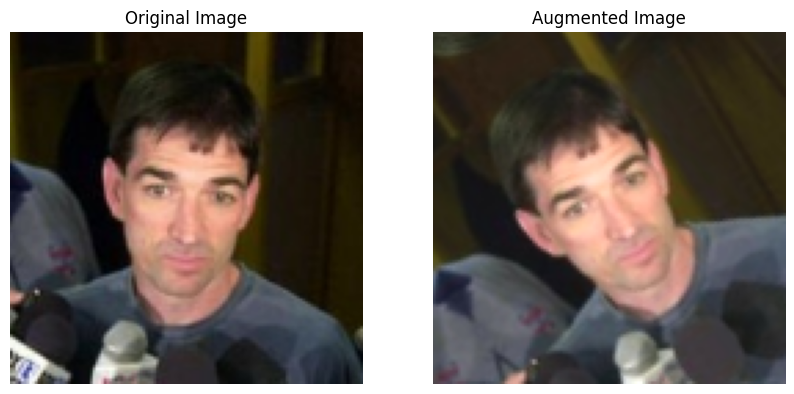

In [8]:
image_path = '/kaggle/input/biggest-genderface-recognition-dataset/faces/man/man_10019.jpg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, (IMG_WIDTH, IMG_HEIGHT))
image_batch = tf.expand_dims(image, axis=0)

augmented_image = data_augmentation(image_batch)
augmented_image = augmented_image[0]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image.numpy().astype("uint8"))
plt.title("Original Image")
plt.axis('off')

# Plot augmented image
plt.subplot(1, 2, 2)
plt.imshow(augmented_image.numpy().astype("uint8"))
plt.title("Augmented Image")
plt.axis('off')

plt.show()

### <div style='width:fit-content;color: #1a1a1a;'>Building The Model<br>
<div style="color:#696969;">Convolutional neural networks perform well on both photos and videos. I utilized two convolutional layers with 3x3 kernels, two fully connected layers, and ultimately a dropout of 40% To avoid overfitting.</div></div>

In [ ]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

with strategy.scope():
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)

    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.006)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )


history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset
)


Epoch 1/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 43s 288ms/step - accuracy: 0.6677 - loss: 0.6541 - val_accuracy: 0.7310 - val_loss: 0.5444
Epoch 2/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 293ms/step - accuracy: 0.7646 - loss: 0.4830 - val_accuracy: 0.7386 - val_loss: 0.5209
Epoch 3/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 292ms/step - accuracy: 0.7933 - loss: 0.4357 - val_accuracy: 0.8124 - val_loss: 0.4150
Epoch 4/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 292ms/step - accuracy: 0.8140 - loss: 0.4064 - val_accuracy: 0.8297 - val_loss: 0.3875
Epoch 5/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 35s 302ms/step - accuracy: 0.8198 - loss: 0.3961 - val_accuracy: 0.8021 - val_loss: 0.4146
Epoch 6/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 292ms/step - accuracy: 0.8391 - loss: 0.3574 - val_accuracy: 0.8557 - val_loss: 0.3328
Epoch 7/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 35s 298ms/step - accuracy: 0.8528 - loss: 0.3329 - val_accuracy: 0.8693 - val_loss: 0.2868
Epoch 8/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 290ms/step - accuracy: 0.8569 - loss: 0

### <div style='width:fit-content;color: #1a1a1a;'>Saving The Model<br>
<div style="color:#696969;">Hooray!! 😁, we got 92.57% on the validation set, let's save it for future use.</div></div>

In [10]:
model.save('/kaggle/working/gender_classification_model_v7.h5')

### <div style='width:fit-content;color: #1a1a1a;'>Visualizing Loss And Accuracy<br>
<div style="color:#696969;">There are alot of spikes when the batch changes.</div></div>

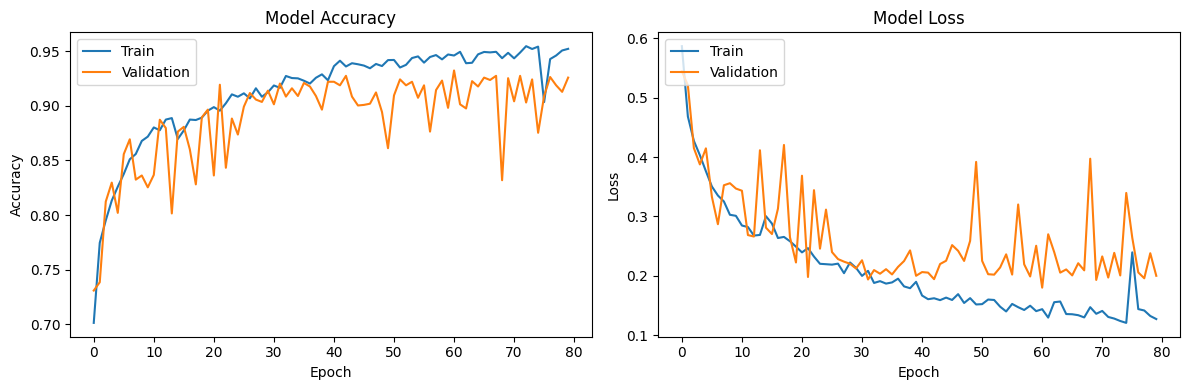

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### <div style='width:fit-content;color: #1a1a1a;'>Let's take a Look At the Kernels<br>
<div style="color:#696969;">These are the estimated kernels, boooring😒.</div></div>

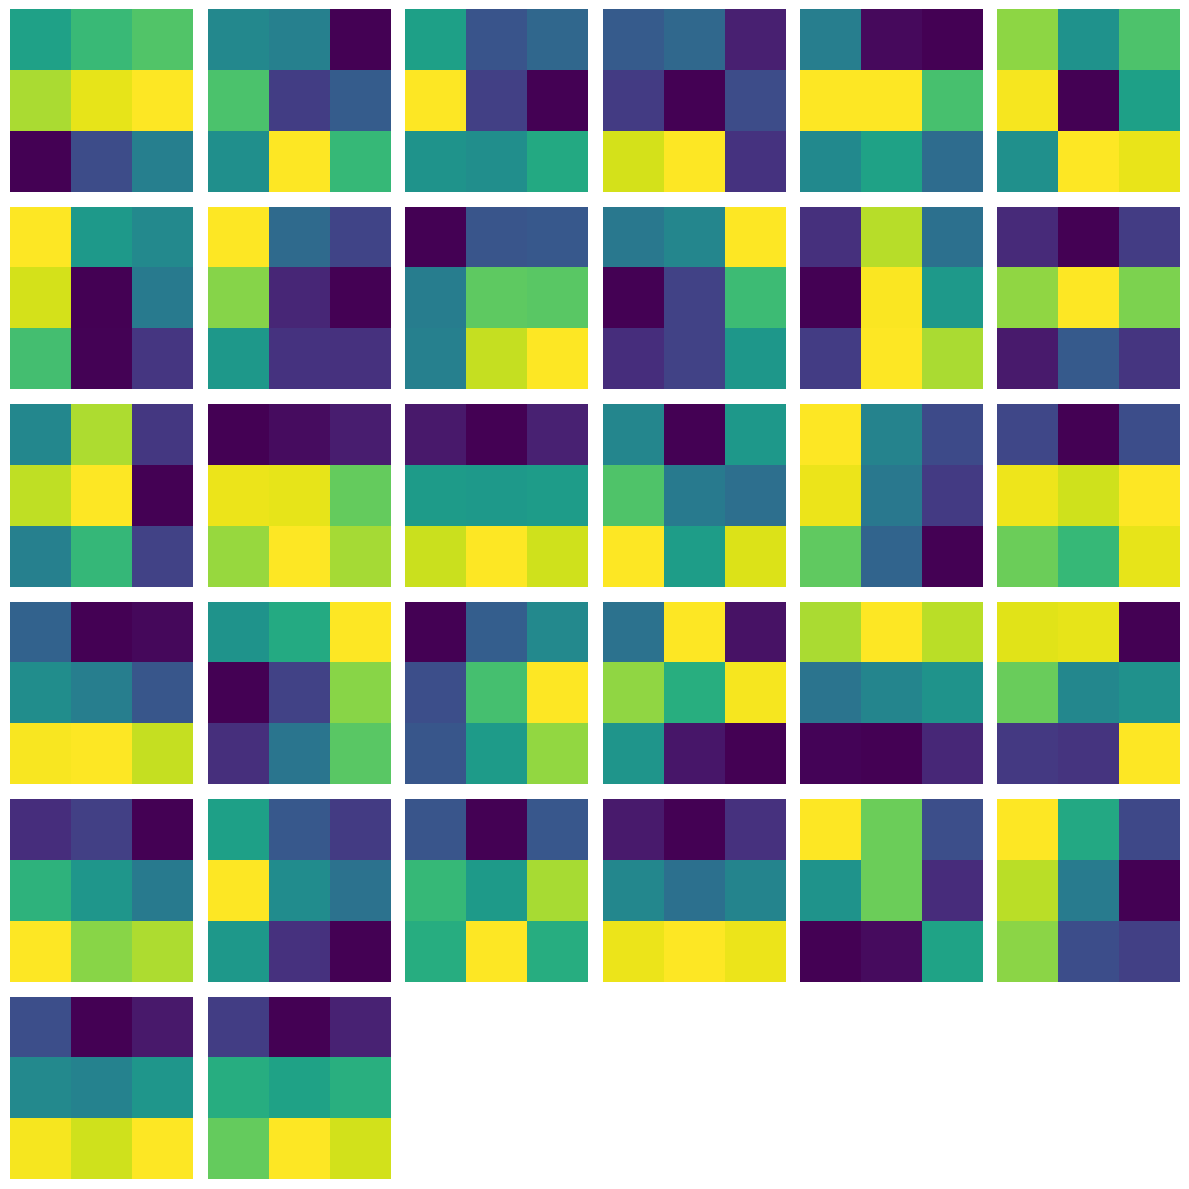

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
conv_layer = None
for layer in model.layers:
    if 'conv' in layer.name:
        conv_layer = layer
        break

if conv_layer:
    kernels = conv_layer.get_weights()[0]  # Get the kernels

    num_kernels = kernels.shape[-1]  # Number of filters
    kernel_size = kernels.shape[0]   # Assuming square kernels (e.g., 3x3, 5x5)

    scale_factor = 10

    # Calculate the grid size (e.g., for 8 kernels, grid size could be 2x4)
    grid_size = int(np.ceil(np.sqrt(num_kernels)))  # Grid with the square root rounded up

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))  # Adjust figure size

    # Flatten the axes for easy iteration
    axes = axes.flatten()

    for i in range(num_kernels):
        kernel = kernels[:, :, 0, i]
        
        kernel = (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))  # Normalize the kernel

        enlarged_kernel = cv2.resize(kernel, (kernel_size * scale_factor, kernel_size * scale_factor), interpolation=cv2.INTER_NEAREST)

        axes[i].imshow(enlarged_kernel)  # Display the enlarged kernel
        axes[i].axis('off')

    # Hide any unused subplots (if there are any)
    for j in range(num_kernels, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()  # Adjust spacing for the grid layout
    plt.show()
else:
    print("No convolutional layer found in the model.")

In [15]:
from tensorflow.keras.preprocessing import image

class_labels = ["Man", "Woman"]

def preprocess_image(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    plt.imshow(img)
    plt.show()
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array
    
def predict_and_show(img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    print(prediction[0][0])
    predicted_class = class_labels[int(prediction[0][0] > 0.5)]
    print(f"Predicted class: {predicted_class}")


### <div style='width:fit-content;color: #1a1a1a;'>Testing The Model<br>
<div style="color:#696969;">it's quite fast too!.</div></div>

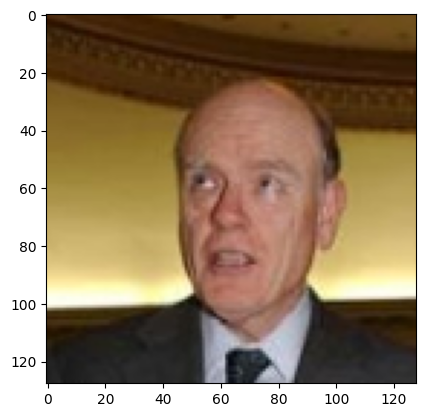

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
8.61138e-06
Predicted class: Man


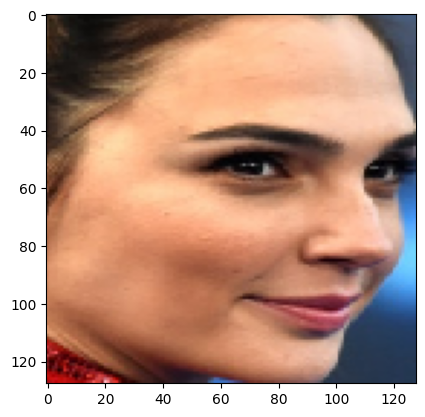

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
0.7214545
Predicted class: Woman


In [20]:

woman_img_path = "/kaggle/input/biggest-genderface-recognition-dataset/faces/woman/woman_1001.jpg" 
man_img_path = "/kaggle/input/biggest-genderface-recognition-dataset/faces/man/man_10001.jpg"


predict_and_show(man_img_path)

predict_and_show(woman_img_path)
